Extracting ../../MNIST/train-images-idx3-ubyte.gz
Extracting ../../MNIST/train-labels-idx1-ubyte.gz
Extracting ../../MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST/t10k-labels-idx1-ubyte.gz
before:  (55000, 784)
before:  (10000, 784)
after:  (55000, 784)
after:  (10000, 784)
Train on 55000 samples, validate on 10000 samples
Epoch 1/50
55000/55000 [==============================] - 5s - loss: 2.3602 - val_loss: 2.3554
Epoch 2/50
55000/55000 [==============================] - 5s - loss: 2.3101 - val_loss: 2.3288
Epoch 3/50
55000/55000 [==============================] - 5s - loss: 2.2924 - val_loss: 2.3124
Epoch 4/50
55000/55000 [==============================] - 5s - loss: 2.2766 - val_loss: 2.2944
Epoch 5/50
55000/55000 [==============================] - 5s - loss: 2.2553 - val_loss: 2.2666
Epoch 6/50
55000/55000 [==============================] - 5s - loss: 2.2234 - val_loss: 2.2411
Epoch 7/50
55000/55000 [==============================] - 5s - loss: 2.2041 - val_loss: 2.2233
E

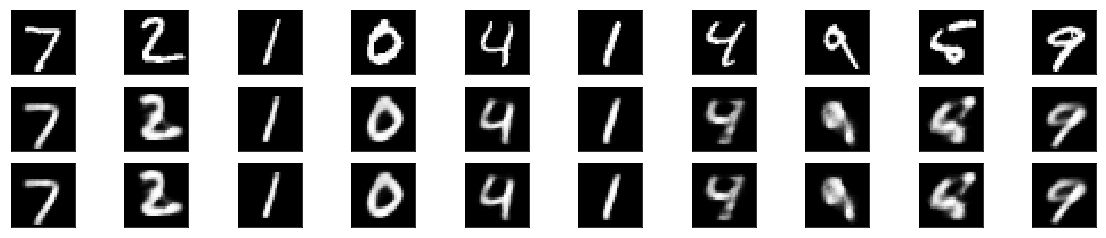

In [4]:
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
from keras import backend as K
# this is the size of our encoded representations
encoding_dim1 = 128
encoding_dim2 = 64
encoding_dim3 = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
decoding_dim1 = 64
decoding_dim2 = 128
decoding_dim3 = 784

####### Deep autoencoder #############
input_img = Input(shape=(decoding_dim3,))
encoded = Dense(encoding_dim1, activation='relu')(input_img)
encoded = Dense(encoding_dim2, activation='relu')(encoded)
encoded = Dense(encoding_dim3, activation='relu')(encoded)

decoded = Dense(decoding_dim1, activation='relu')(encoded)
decoded = Dense(decoding_dim2, activation='relu')(decoded)
decoded = Dense(decoding_dim3, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

###### Compile and Training
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
#换一个优化器结果好一些， 损失函数用多分类的比二分类的好
autoencoder.compile(optimizer='rmsprop', #loss='binary_crossentropy')
              loss='categorical_crossentropy')

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../../MNIST') #don't use one hot encoding
x_train, x_test = mnist.train.images, mnist.test.images

## normalize all values between 0 and 1, flatten the 28*28 image to 784
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print("before: ", x_train.shape)
print("before: ", x_test.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) #flatten
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print("after: ", x_train.shape)
print("after: ", x_test.shape)

#after 50 epoch, loss value ~ 0.11 stably
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

################ Separate Encoder Model for Reconstruction Evaluation ##############
# using well-trained network to predict data
# encoder_layer = autoencoder.layers[0](input_img)
# encoder_layer = autoencoder.layers[1](encoder_layer)
# encoder_layer = autoencoder.layers[2](encoder_layer)
# print(encoder_layer.shape)
encoder = Model(input_img, encoded) # automatically take everything it needed

# 取中间结果，对比原encoder
get_encoder_output = K.function([autoencoder.layers[0].input], [autoencoder.layers[2].output])
get_decoder_output = K.function([autoencoder.layers[3].input], [autoencoder.layers[-1].output])

################# Separate Decoder Model #############
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim3,))
decoder_layer = autoencoder.layers[-3](encoded_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
# create the decoder model
decoder = Model(encoded_input, decoder_layer)

############ Visualize the reconstructed inputs
# encode and decode some digits, note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

functional_encoder_output = get_encoder_output([x_test])[0]
functional_decoder_output = get_decoder_output([functional_encoder_output])[0]

import matplotlib.pyplot as plt
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
     # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display function reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(functional_decoder_output[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()


In [ ]:
# 50 epoch loss: 2.0803 - val_loss: 2.1101